In [6]:
import matplotlib.pyplot as plt
import math
import numpy as np
from cogrecon.core.similarity_transform import similarity_transform
import cogrecon.core.tools as tools
import scipy.spatial.distance
import operator
import itertools

In [7]:
def points_in_circle(radius, num_points=100):
    # noinspection PyCompatibility
    return [(math.cos(2 * np.pi / num_points * xx) * radius, math.sin(2 * np.pi / num_points * xx) * radius)
            for xx in xrange(0, num_points + 1)]

def plot_heatmap(x_d, y_d, e, x_r, y_r, x_axis_label, fig_num):
    vis_shape = (len(y_r), len(x_r))
    min_error = min(e)
    max_error = max(e)
    print("shape={0}".format(vis_shape))
    print("min={0}, max={1}".format(min_error, max_error))
    xx = np.reshape(np.array(x_d), vis_shape)
    yy = np.reshape(np.array(y_d), vis_shape)
    z = np.reshape(np.array(e), vis_shape)
    plt.figure(fig_num)
    plt.contourf(xx, yy, z, cmap='RdBu', vmin=min_error, vmax=max_error)
    plt.axis([xx.min(), xx.max(), yy.min(), yy.max()])
    plt.colorbar()
    plt.xlabel(x_axis_label)
    plt.ylabel("Noise Level (proportion)")

In [13]:
enable_translation = True
enable_scaling = True
enable_rotation = True

# Test variable ranges; all ranges are proportions of space size [0, 1]
noise_range = np.linspace(0, 0.5, 10)
iterations = 50
resolution = 2

In [14]:
if enable_translation:
    translation_range = map(lambda p: points_in_circle(p, 10), np.linspace(0.05, 0.5, 21))
else:
    translation_range = [[(0, 0)]]  # Identity
if enable_scaling:
    scaling_range = np.linspace(-0.5, 0.5, resolution)
else:
    scaling_range = [1]  # Identity
if enable_rotation:
    rotation_range = np.linspace(-np.pi, np.pi, resolution)
else:
    rotation_range = [0]  # Identity
num_point_range = np.linspace(5, 5, 1)  # Identity


# Test translation only
test_combinations = list(
    itertools.product(*[num_point_range, noise_range, translation_range, scaling_range, rotation_range]))
translations = []
scalings = []
points = []
rotations = []
noises = []
errors = []
for idx, (n, noise_level, t, s, r) in enumerate(test_combinations):
    if idx % 100 == 0:
        print('Running test combination {0}/{1}.'.format(idx, len(test_combinations)))
    results = []
    expected_magnitude = np.linalg.norm([t[0][0], t[0][1]])
    co, si = np.cos(r), np.sin(r)
    rot_matrix = np.array([[co, -si], [si, co]])
    for i in range(0, iterations):
        # Generate noised test points
        correct, random_input = tools.generate_random_test_points(number_of_points=int(n), dimension=2,
                                                                  shuffle_points=False,
                                                                  noise=noise_level, num_rerandomed_points=0)
        for x, y in t:
            transformed_input = [list((np.array(new_point) + np.array([x, y])).dot(rot_matrix) * s) for new_point in
                                 random_input]  # Apply known translation
            # noinspection PyRedeclaration
            rot, scaling, translation = similarity_transform(np.array(correct), np.array(transformed_input))

            output = [list((np.array(new_point) - np.array(translation)).dot(rot) / scaling) for new_point in
                      transformed_input]  # Apply known translation

            error = np.mean(map(lambda p: scipy.spatial.distance.euclidean(p[0], p[1]), zip(random_input, output)))
            results.append(error)

    scalings.append(s)
    rotations.append(r)
    points.append(n)
    errors.append(np.mean(results))
    translations.append(expected_magnitude)
    noises.append(noise_level)

Running test combination 0/840.
Running test combination 100/840.
Running test combination 200/840.
Running test combination 300/840.
Running test combination 400/840.
Running test combination 500/840.
Running test combination 600/840.
Running test combination 700/840.
Running test combination 800/840.


shape=(10, 21)
min=2.96939306964e-16, max=0.377504458639
shape=(10, 2)
min=3.07772437717e-16, max=0.368710678744
shape=(10, 2)
min=3.10045833461e-16, max=0.368972276204


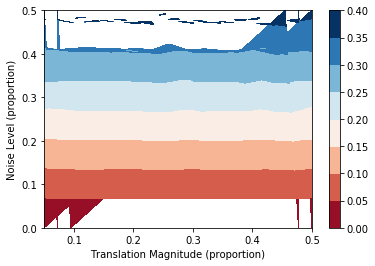

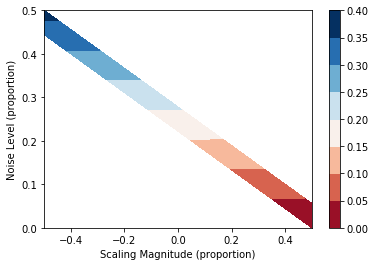

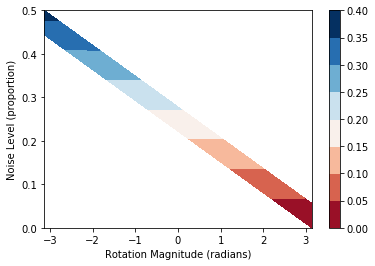

In [15]:
if enable_translation:
    all_data = zip(points, noises, errors, translations, scalings, rotations)
    all_data_sorted = sorted(all_data, key=operator.itemgetter(3))
    _, ns, es, ts, _, _ = zip(*all_data_sorted)
    partition_length = len(all_data) / (len(translation_range) * len(noise_range))
    ns = np.mean(np.array(ns).reshape(-1, partition_length), axis=1)
    es = np.mean(np.array(es).reshape(-1, partition_length), axis=1)
    ts = np.mean(np.array(ts).reshape(-1, partition_length), axis=1)
    plot_heatmap(ts, ns, es, translation_range, noise_range, "Translation Magnitude (proportion)", 1)
if enable_scaling:
    all_data = zip(points, noises, errors, translations, scalings, rotations)
    all_data_sorted = sorted(all_data, key=operator.itemgetter(4))
    _, ns, es, _, ss, _ = zip(*all_data_sorted)
    partition_length = len(all_data) / (len(scaling_range) * len(noise_range))
    ns = np.mean(np.array(ns).reshape(-1, partition_length), axis=1)
    es = np.mean(np.array(es).reshape(-1, partition_length), axis=1)
    ss = np.mean(np.array(ss).reshape(-1, partition_length), axis=1)
    plot_heatmap(ss, ns, es, scaling_range, noise_range, "Scaling Magnitude (proportion)", 2)
if enable_rotation:
    all_data = zip(points, noises, errors, translations, scalings, rotations)
    all_data_sorted = sorted(all_data, key=operator.itemgetter(5))
    _, ns, es, _, _, rs = zip(*all_data_sorted)
    partition_length = len(all_data) / (len(rotation_range) * len(noise_range))
    ns = np.mean(np.array(ns).reshape(-1, partition_length), axis=1)
    es = np.mean(np.array(es).reshape(-1, partition_length), axis=1)
    rs = np.mean(np.array(rs).reshape(-1, partition_length), axis=1)
    plot_heatmap(rs, ns, es, rotation_range, noise_range, "Rotation Magnitude (radians)", 3)

plt.show()